# Token Count Exploration
It would be really useful for deployment to know our input/output expectations. We know that our output is quite verbose relative to the input since the explanations are long. With a model like `mistralai/Mistral-7B-Instruct-v0.3` Id expect that our real output with explanations will be shorter. Thats perfect since our training data will give us a reliable upper bound, which is great to prevent truncation.

Lets figure out how to split input and output tokens, and then we can build a histogram.

## Config

In [1]:
INPUT_DATASET = 'derek-thomas/labeled-multiple-choice-explained-falcon-tokenized'
BASE_MODEL = 'tiiuae/Falcon3-7B-Instruct'

## Setup

In [2]:
from huggingface_hub import login, get_token
login()

In [3]:
from transformers import AutoTokenizer
from datasets import load_dataset

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, token=get_token())

dataset = load_dataset(INPUT_DATASET, split='train')
df = dataset.to_pandas()

## Exploration

In [4]:
df['conversation_RFA_gpt3_5'].iloc[0]

array([{'content': 'Answer the Question and include your reasoning and the final answer in a json like: {"reasoning": <reasoning about the answer>, "final_answer": <letter corresponding to the answer>}.', 'role': 'system'},
       {'content': 'Question: What can genetic material have?\nAnswer Choices: (a) Resistance (b) Mutations (c) Clorophyll (d) Nucleotide (e) Symmetry (f) Allow growth (g) Contamination (h) Warmth', 'role': 'user'},
       {'content': "{'reasoning': 'a) Resistance: Genetic material can carry genes that provide resistance to certain diseases or environmental factors, but this is not a characteristic of genetic material itself. Therefore, this option is incorrect.\\n\\nc) Chlorophyll: Chlorophyll is a pigment found in plants that is responsible for photosynthesis. It is not a characteristic of genetic material. Therefore, this option is incorrect.\\n\\nd) Nucleotide: Nucleotides are the building blocks of DNA and RNA, which are types of genetic material. However, this

In [5]:
print(tokenizer.apply_chat_template(df['conversation_RFA_gpt3_5'].iloc[0], tokenize=False))

<|system|>
Answer the Question and include your reasoning and the final answer in a json like: {"reasoning": <reasoning about the answer>, "final_answer": <letter corresponding to the answer>}.
<|user|>
Question: What can genetic material have?
Answer Choices: (a) Resistance (b) Mutations (c) Clorophyll (d) Nucleotide (e) Symmetry (f) Allow growth (g) Contamination (h) Warmth
<|assistant|>
{'reasoning': 'a) Resistance: Genetic material can carry genes that provide resistance to certain diseases or environmental factors, but this is not a characteristic of genetic material itself. Therefore, this option is incorrect.\n\nc) Chlorophyll: Chlorophyll is a pigment found in plants that is responsible for photosynthesis. It is not a characteristic of genetic material. Therefore, this option is incorrect.\n\nd) Nucleotide: Nucleotides are the building blocks of DNA and RNA, which are types of genetic material. However, this option is too broad and does not fully answer the question. Therefore,

Great, we can see that there is a special token `<|assistant|>` that we will want to split on. We can count the tokens before and including `<|assistant|>` and that should be our input tokens, and the tokens after will be our output tokens.

Lets count those for each row in `conversation_RFA` and build a histogram of the results. `conversation_RFA` should be a good max since its just a reshuffle or superset of the other columns.

In [6]:
def split_and_measure(lst):
    # Encode the subsequence dynamically
    subsequence = tokenizer.encode('<|assistant|>', add_special_tokens=False)
    
    # Check if the subsequence exists in the list
    for i in range(len(lst) - len(subsequence) + 1):
        if lst[i:i + len(subsequence)] == subsequence:
            input_length = i  # Elements before the subsequence
            output_length = len(lst) - input_length  # Includes subsequence and everything after
            return input_length, output_length
    
    # If the subsequence is not found
    return len(lst), 0


In [7]:
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer

# Load the dataset and convert it to a DataFrame
dataset = load_dataset(INPUT_DATASET, split='test')
df = dataset.to_pandas()

df_token_gpt3_5 = df[['conversation_RFA_gpt3_5']].copy()
df_token_gpt3_5['tokens_gpt3_5'] = df['conversation_RFA_gpt3_5'].apply(lambda x: tokenizer.apply_chat_template(x))

df_token_falcon = df[['conversation_RFA_falcon']].copy()
df_token_falcon['tokens_falcon'] = df['conversation_RFA_falcon'].apply(lambda x: tokenizer.apply_chat_template(x))


df_token_gpt3_5[['input_tokens', 'output_tokens']] = df_token_gpt3_5['tokens_gpt3_5'].apply(split_and_measure).apply(pd.Series)
df_token_falcon[['input_tokens', 'output_tokens']] = df_token_falcon['tokens_falcon'].apply(split_and_measure).apply(pd.Series)

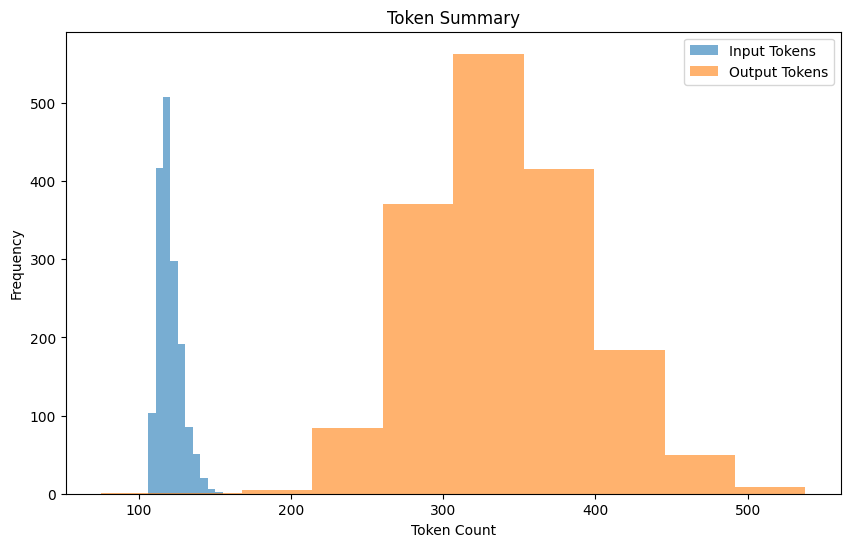

In [8]:
import matplotlib.pyplot as plt

# Plot the histograms
plt.figure(figsize=(10, 6))

# Histogram for Input Tokens
plt.hist(df_token_gpt3_5['input_tokens'], bins=10, alpha=0.6, label='Input Tokens')

# Histogram for Output Tokens
plt.hist(df_token_gpt3_5['output_tokens'], bins=10, alpha=0.6, label='Output Tokens')

# Add titles and labels
plt.title("Token Summary")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.legend()

# Show the plot
plt.show()


In [9]:
print(f"Our Max Input Tokens:\t{max(df_token_gpt3_5.input_tokens)}\nOur Max Output Tokens:\t{max(df_token_gpt3_5.output_tokens)}")

Our Max Input Tokens:	155
Our Max Output Tokens:	538


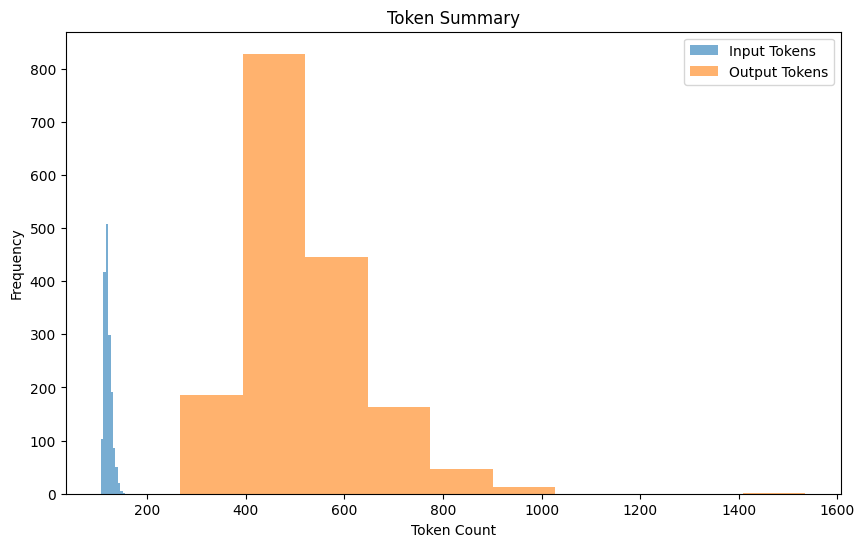

In [10]:
import matplotlib.pyplot as plt

# Plot the histograms
plt.figure(figsize=(10, 6))

# Histogram for Input Tokens
plt.hist(df_token_falcon['input_tokens'], bins=10, alpha=0.6, label='Input Tokens')

# Histogram for Output Tokens
plt.hist(df_token_falcon['output_tokens'], bins=10, alpha=0.6, label='Output Tokens')

# Add titles and labels
plt.title("Token Summary")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.legend()

# Show the plot
plt.show()


In [11]:
print(f"Our Max Input Tokens:\t{max(df_token_falcon.input_tokens)}\nOur Max Output Tokens:\t{max(df_token_falcon.output_tokens)}")

Our Max Input Tokens:	155
Our Max Output Tokens:	1535
